In [1]:
# Austin Griffith
# Simple Portfolio Optimization
# Python 3.6.3
# 1/17/2018

import pandas as pd
import numpy as np
from gurobipy import *
import math
import os
import matplotlib.pyplot as plt

# create directory for graphs
name = 'data'
if os.path.exists(name) == False:
    os.makedirs(name)

In [2]:
# read in monthly returns data
path = 'C:/Git_Profile/simple_portfolio_optimization/'
ret = pd.read_csv(path+'monthly_returns.csv')
ret = ret.set_index('Unnamed: 0')
ret = ret.reset_index(drop=True)

# summary statistics of the data
avg = ret.mean()
std = ret.std()
cov = ret.cov()

In [3]:
# outputting average and std deviation of returns
# and covariance matrix
print('Average Returns')
print(avg)
print('\nStd Deviation of Returns')
print(std)
print('\nCovariance Matrix of Returns')
print(cov)

Average Returns
AMZN     0.037707
AXP      0.000661
BA       0.022156
GOOGL    0.017331
HON      0.010696
KO       0.002506
MSFT     0.018021
SPY      0.005301
UNH      0.020032
dtype: float64

Std Deviation of Returns
AMZN     0.071566
AXP      0.058520
BA       0.066432
GOOGL    0.058753
HON      0.031648
KO       0.031361
MSFT     0.069342
SPY      0.027275
UNH      0.040445
dtype: float64

Covariance Matrix of Returns
           AMZN       AXP        BA     GOOGL       HON        KO      MSFT  \
AMZN   0.005122 -0.000138  0.001531  0.002591  0.000594  0.000730  0.001932   
AXP   -0.000138  0.003425  0.001325 -0.000097  0.000403 -0.000113  0.000802   
BA     0.001531  0.001325  0.004413  0.000909  0.000932  0.000544  0.000680   
GOOGL  0.002591 -0.000097  0.000909  0.003452  0.000651  0.000997  0.002445   
HON    0.000594  0.000403  0.000932  0.000651  0.001002  0.000452  0.000681   
KO     0.000730 -0.000113  0.000544  0.000997  0.000452  0.000984  0.001200   
MSFT   0.001932  0.00

In [4]:
# create new model for the minimum risk portfolio
model = Model('min_risk')

# labels and variables for each stock
tickers = ret.columns
variables = pd.Series(model.addVars(tickers),index=tickers)

# determine the risk using the covariance matrix
port_risk = cov.dot(variables).dot(variables)

In [5]:
# set the model to minimize
model.setObjective(port_risk,GRB.MINIMIZE)

# constraints
# weights add up to 1
model.addConstr(variables.sum() == 1,'weights')
model.update()
# no shorting stocks(w >= 0)
model.setParam('OutputFlag',0)
model.update()

# optimize model, finds minimum risk portfolio with constraints
model.optimize()

In [6]:
# display variables and respective weights
n = 0
weights = {}
for v in variables:
    weights.update({tickers[n]:v.x})
    n = n + 1
weights = pd.DataFrame([weights])
weights = weights.transpose()
weights.columns = ['Weights']

print('\nMin Risk, Optimal Weights Per Stock')
print(weights['Weights'])


Min Risk, Optimal Weights Per Stock
AMZN     2.020708e-02
AXP      7.662483e-02
BA       6.980067e-08
GOOGL    2.364396e-07
HON      1.069820e-02
KO       4.249617e-01
MSFT     8.328121e-08
SPY      2.212701e-01
UNH      2.462377e-01
Name: Weights, dtype: float64


In [7]:
# organize dataframes
main = pd.concat([avg,std,weights],axis=1)
main.columns = ['Avg','Std','Weights']

# save values to csv
cov.to_csv(name+'/CovarianceRet.csv')
main.to_csv(name+'/MainRet.csv')

In [8]:
# minimum risk values
# optimal objective value
print('\nMinimized Portfolio Variance : '+str(port_risk.getValue()))
# volatility
min_vol = math.sqrt(port_risk.getValue())
print('Volatility : '+str(min_vol))
# expected return using optimized weights
port_return = avg.dot(variables)
Rmin = port_return.getValue()
print('Expected Return (Rmin) : '+str(Rmin))


Minimized Portfolio Variance : 0.0005231075180047175
Volatility : 0.022871543848300174
Expected Return (Rmin) : 0.008097325139818718


In [9]:
# maximum return value among all stocks
Rmax = avg.max()

# return constraint
target = model.addConstr(port_return == Rmin, 'target')

# calculate values of efficient frontier
# set right hand side of target value for returns
# iterate through the range of returns from Rmin to Rmax
eff = {}
iterations = 50
diff = (Rmax-Rmin)/(iterations-1)
Rrange = np.arange(Rmin,Rmax+diff,diff)
for r in Rrange:
    target.rhs = r
    model.optimize()
    temp = math.sqrt(port_risk.getValue())
    eff.update({temp:r})

# organize dataframe for efficient frontier
frontier = pd.DataFrame([eff]).transpose()
frontier.columns = ['Returns']
frontier['Risk'] = frontier.index
frontier = frontier.reset_index(drop=True)

# output and save values of efficient frontier
print('\nEfficient Frontier')
print(frontier)
frontier.to_csv(name+'/EffFrontier.csv')


Efficient Frontier
     Returns      Risk
0   0.008097  0.022872
1   0.008702  0.022886
2   0.009306  0.022929
3   0.009910  0.023000
4   0.010514  0.023100
5   0.011119  0.023227
6   0.011723  0.023381
7   0.012327  0.023562
8   0.012931  0.023770
9   0.013536  0.024011
10  0.014140  0.024283
11  0.014744  0.024582
12  0.015349  0.024905
13  0.015953  0.025251
14  0.016557  0.025618
15  0.017161  0.026007
16  0.017766  0.026416
17  0.018370  0.026844
18  0.018974  0.027290
19  0.019578  0.027753
20  0.020183  0.028233
21  0.020787  0.028729
22  0.021391  0.029244
23  0.021996  0.029778
24  0.022600  0.030330
25  0.023204  0.030899
26  0.023808  0.031485
27  0.024413  0.032095
28  0.025017  0.032747
29  0.025621  0.033507
30  0.026225  0.034393
31  0.026830  0.035395
32  0.027434  0.036505
33  0.028038  0.037713
34  0.028642  0.039073
35  0.029247  0.040595
36  0.029851  0.042263
37  0.030455  0.044060
38  0.031060  0.045971
39  0.031664  0.047982
40  0.032268  0.050081
41  0.032872  

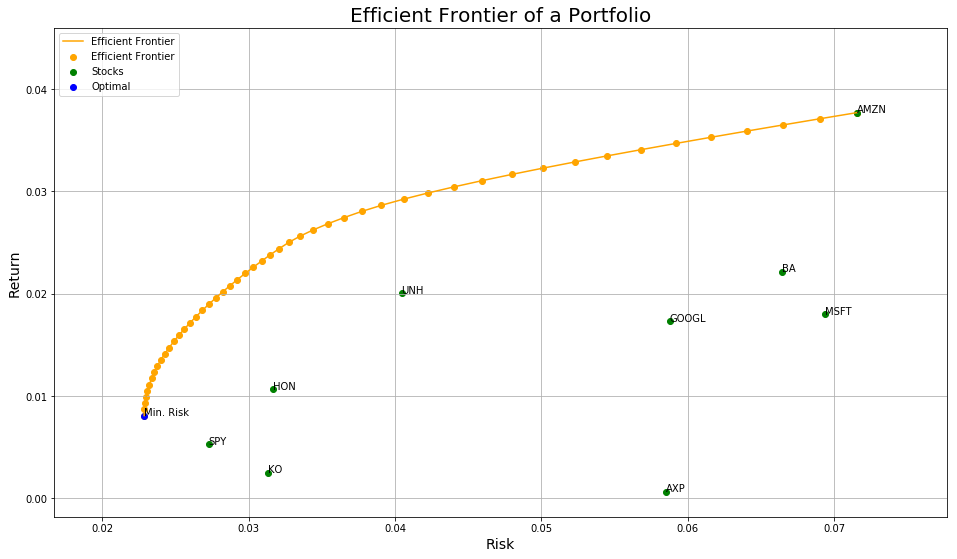

In [10]:
# plot of the efficient frontier from Rmin to Rmax
# initialize plot, set labels
fig, ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(16,9)
ax.set_title('Efficient Frontier of a Portfolio',fontsize=20)
ax.set_xlabel('Risk',fontsize=14)
ax.set_ylabel('Return',fontsize=14)

# plot the efficient frontier
# do this first to allow individual points later on to overlay
ax.scatter(x=frontier['Risk'],y=frontier['Returns'],color='orange',label='Efficient Frontier')
ax.plot(x=frontier['Risk'],y=frontier['Returns'],color='orange')
temp = pd.DataFrame([eff]).transpose()
temp.columns = ['Efficient Frontier']
temp.plot(color='orange',label='Efficient Frontier',ax=ax)

# average return/volatility for each individual stock
ax.scatter(x=std,y=avg,color='green',label='Stocks')
i = 0
for stock in tickers:
    ax.annotate(stock,(std[i],avg[i]))
    i = i + 1

# show the minimum risk portfolio
ax.scatter(x=min_vol,y=Rmin,color='blue',label='Optimal')
ax.annotate('Min. Risk',(min_vol,Rmin))

# additional edits to the graph
ax.grid()
ax.legend(loc='upper left')
fig.savefig(name+'/EfficientFrontier.png')